### **Model Comparison and Selection**

Let's compare all models and select the best one for our final predictions.

In [8]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import catboost as cb
import time
import optuna
import joblib # for saving the model
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


import warnings
warnings.filterwarnings('ignore')

#import your models 



load the dataset

In [9]:
X = pd.read_csv('X_processed.csv')
X_test = pd.read_csv('X_test_processed.csv')
y = pd.read_csv('y_processed.csv')

# Drop if still in the data
if 'PID' in X.columns:
    X = X.drop(columns=['PID'])
if 'site' in X.columns:
    X = X.drop(columns=['site'])

if 'PID' in X_test.columns:
    X_test = X_test.drop(columns=['PID'])
if 'site' in X_test.columns:
    X_test = X_test.drop(columns=['site'])


#split the data into training and validation sets 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (6195, 31)
y_train shape: (6195, 11)


LOAD THE SAVED MODEL

In [10]:
import pickle

##with open("cb_results.pkl", "rb") as f:
    #cb_results = pickle.load(f)

with open("xgb_results.pkl", "rb") as f:
    xgb_results = pickle.load(f)
with open('lgb_results.pkl','rb') as f:
    lgb_results = pickle.load(f)

with open("cb_results.pkl","rb") as f:
    cb_results = pickle.load(f)  


### **Model Comparison and Selection**

Let's compare all models and select the best one for our final predictions.

In [11]:
# Combine the results
models = [xgb_results, lgb_results, cb_results]

#create a dataframe to hold the results
comparison_df = pd.DataFrame({
    'Model':[model['name'] for model in models]
    ,'Validation MAE':[model['val_mae'] for model in models]
    ,'Validation RMSE':[model['val_rmse'] for model in models]
    ,'Train time':[model['train_time'] for model in models]
})




# Only keep the relevant column
comparison_df = comparison_df.sort_values(by='Validation MAE')

# Display it
comparison_df


,Model,Validation MAE,Validation RMSE,Train time
1,LightGBM,155.459391,460.514059,20.533493
0,XGBoost,156.627731,474.168318,82.076126
2,CatBoost,159.013677,480.149006,109.329244


PLOT THE COMPARISON

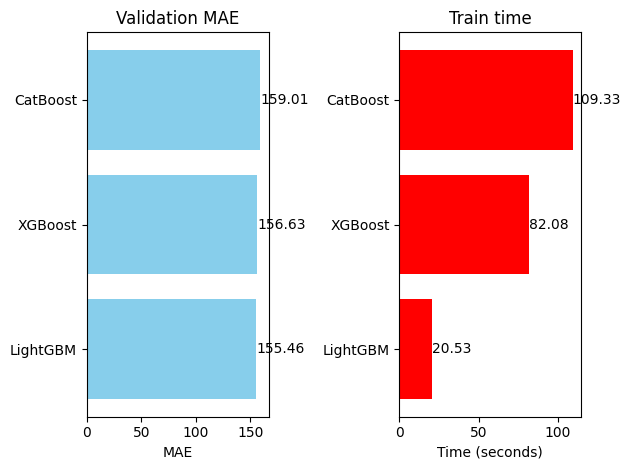

In [12]:
import matplotlib.pyplot as plt


#bar plot for validation rmse
plt.subplot(1,2,1)
plt.barh(comparison_df['Model'],comparison_df['Validation MAE'], color='skyblue')
plt.title('Models by Validation MAE')
plt.title("Validation MAE")
plt.xlabel("MAE")


#anotating a bar chart
for i,v in enumerate(comparison_df['Validation MAE']):#looping through the values
    #adds text anotation to the bar chart
    plt.text(v + 0.01, i,f"{v:.2f}",va='center')

#bar plot for train time 
plt.subplot(1,2,2)
plt.barh(comparison_df['Model'],comparison_df['Train time'], color='red')
plt.title('Models by Train time ')
plt.title('Train time')
plt.xlabel('Time (seconds)')
 #anotating a bar chart
for i ,v in enumerate(comparison_df['Train time']):
    #adds text anotation to the bar chart
    plt.text(v + 0.01, i ,f"{v:.2f}",va='center')


    plt.tight_layout()
plt.show()#ploting the trained time



CHECKING FOR OVERFITTING













overfitting occures when a model performs well on training data but poorly in test data / validation data

In [13]:
#create a dataframe of overfiting analyisis
overfitting_df = pd.DataFrame({
    'Model': [model['name'] for model in models],
    'Training MAE': [model['train_mae'] for model in models],
    'Validation MAE': [model['val_mae'] for model in models],
    'Difference': [model['val_mae'] - model['train_mae'] for model in models],
    'Training RMSE': [model['train_rmse'] for model in models],
    'Validation RMSE': [model['val_rmse'] for model in models]
})

# Sort by the difference between validation and training MAE
overfitting_df = overfitting_df.sort_values('Difference', ascending=False)
overfitting_df

,Model,Training MAE,Validation MAE,Difference,Training RMSE,Validation RMSE
1,LightGBM,76.834711,155.459391,78.624681,222.198496,460.514059
2,CatBoost,86.261332,159.013677,72.752345,230.552246,480.149006
0,XGBoost,92.550728,156.627731,64.077003,269.812695,474.168318


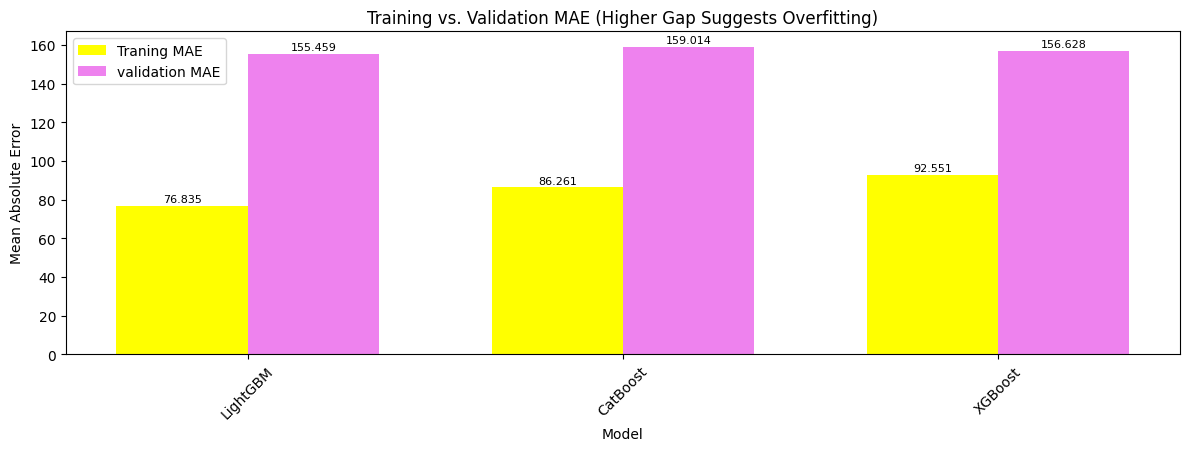

In [18]:
#lets plot the gaps
# Visualize overfitting
plt.figure(figsize=(12, 8))

#plt mae comparison
plt.subplot(2,1,1)
x = np.arange(len(models))
width = 0.35


#get the models name in order
models_name = overfitting_df['Model']

train_mae_bars = plt.bar(x - width/2, overfitting_df['Training MAE'],width,label='Traning MAE',color='yellow')
val_mae_bars = plt.bar(x + width/2, overfitting_df['Validation MAE'],width,label='validation MAE',color='violet')


plt.xlabel('Model')
plt.ylabel('Mean Absolute Error')
plt.title('Training vs. Validation MAE (Higher Gap Suggests Overfitting)')
plt.xticks(x, models_name, rotation=45)
plt.legend()


#add value labels at the bars
for i , bar in enumerate(train_mae_bars):
    #adds text to the bar chart 
    plt.text(bar.get_x() + bar.get_width()/2,bar.get_height() + 1,
             f'{overfitting_df["Training MAE"].iloc[i]:.3f}',
               ha='center', va='bottom', fontsize=8)
for i , bar in enumerate(val_mae_bars):
    #adds text to the bar 
    plt.text(bar.get_x() + bar.get_width()/2,bar.get_height() + 1,
              f'{overfitting_df["Validation MAE"].iloc[i]:.3f}',
               ha='center', va='bottom', fontsize=8)
             




plt.tight_layout()
plt.show()

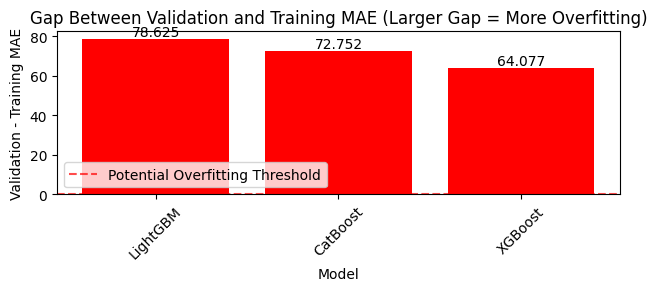

In [23]:
#plot the gap diference between the validation and training MAE
plt.subplot(2,1,1)
plt.bar(models_name,overfitting_df['Difference'] , color=['red' if diff > 0.1  else 'green' for diff in overfitting_df['Difference']])
plt.axhline(y=0.1, color='r', linestyle='--', alpha=0.7, label='Potential Overfitting Threshold')
plt.xlabel('Model')
plt.ylabel('Validation - Training MAE')
plt.title('Gap Between Validation and Training MAE (Larger Gap = More Overfitting)')
plt.xticks(rotation=45)
plt.legend()

# Add value labels
for i, diff in enumerate(overfitting_df['Difference']):
    plt.text(i, diff + 0.005, f'{diff:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()